# import libraries 

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings("ignore")

# 📥 Data Loading & Overview

In [2]:
train_df = pd.read_csv(r'/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv')  # Replace with your file path
val_df = pd.read_csv(r'/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv') 

In [3]:
train_df.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column                                                 Non-Null Count  Dtype 
---  ------                                                 --------------  ----- 
 0   2401                                                   74681 non-null  int64 
 1   Borderlands                                            74681 non-null  object
 2   Positive                                               74681 non-null  object
 3   im getting on borderlands and i will murder you all ,  73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [5]:
train_df.columns = ['Tweet_ID', 'Entity', 'Sentiment', 'Tweet_Content']
train_df.head()

,Tweet_ID,Entity,Sentiment,Tweet_Content
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


# 🧹 Data Cleaning & Preprocessing

In [6]:
train_df.isna().sum()

Tweet_ID           0
Entity             0
Sentiment          0
Tweet_Content    686
dtype: int64

In [7]:
train_df = train_df.dropna(subset=['Tweet_Content'])
train_df.isna().sum()

Tweet_ID         0
Entity           0
Sentiment        0
Tweet_Content    0
dtype: int64

In [8]:
train_df['Tweet_Content'].value_counts()

Tweet_Content
                                                                                                                                                                                                                                                                                     172
At the same time, despite the fact that there are currently some 100 million people living below the poverty line, most of them do not have access to health services and do not have access to health care, while most of them do not have access to health care.                   172
It is not the first time that the EU Commission has taken such a step.                                                                                                                                                                                                               172
<unk>                                                                                                                                          

In [9]:
import nltk

stop_words = set(stopwords.words('english'))

In [10]:
import string

def preprocess_text(text):
    text = text.lower()
    
    # Remove emojis
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    # Continue other preprocessing
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'<unk>', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Remove stop words
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    return text if text else None


In [11]:
# Apply preprocessing to the dataset
train_df['clean_text'] = train_df['Tweet_Content'].apply(preprocess_text)


In [12]:
train_df['clean_text'].value_counts()

clean_text
first time eu commission taken step.                                                                                               172
time, despite fact currently million people living poverty line, access health services access health care, access health care.    172
wow                                                                                                                                 82
.                                                                                                                                   79
wtf                                                                                                                                 57
                                                                                                                                  ... 
found perfect setting zeus                                                                                                           1
taking advantage ideal opportunity,         

In [13]:
train_df.isna().sum()

Tweet_ID            0
Entity              0
Sentiment           0
Tweet_Content       0
clean_text       1594
dtype: int64

In [14]:
train_df = train_df.dropna(subset=['clean_text'])
train_df.isna().sum()

Tweet_ID         0
Entity           0
Sentiment        0
Tweet_Content    0
clean_text       0
dtype: int64

In [15]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_df['Sentiment'] = le.fit_transform(train_df['Sentiment'])

# 🧼 Exploratory Data Analysis (EDA)

## 1. Count plot for Sentiment Classes 

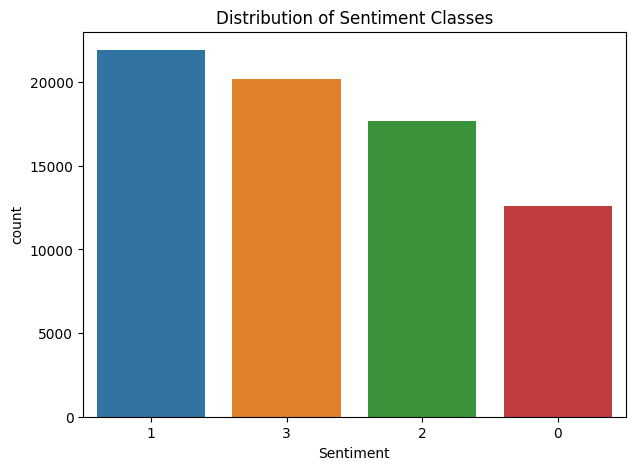

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7,5))
sns.countplot(data=train_df, x='Sentiment', order=train_df['Sentiment'].value_counts().index)
plt.title('Distribution of Sentiment Classes')
plt.show()


 ## 2. Word Cloud Visualization for Each Sentiment

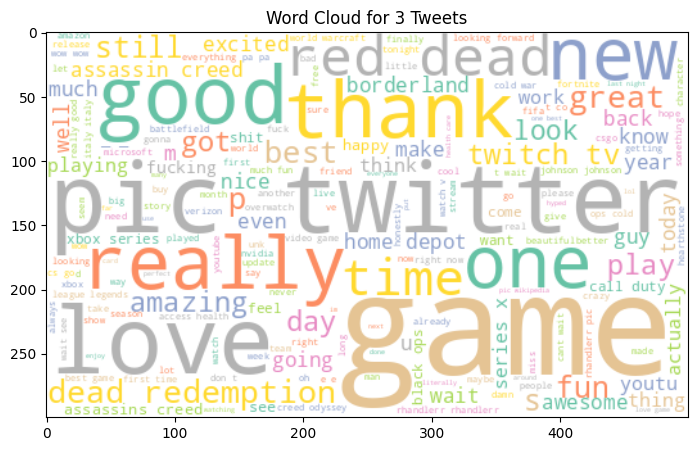

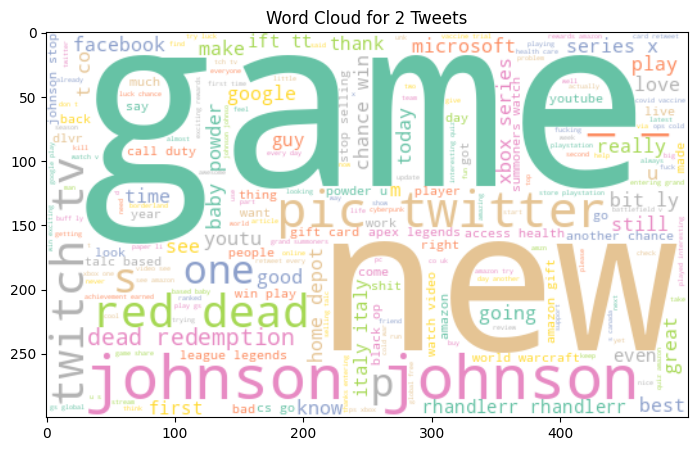

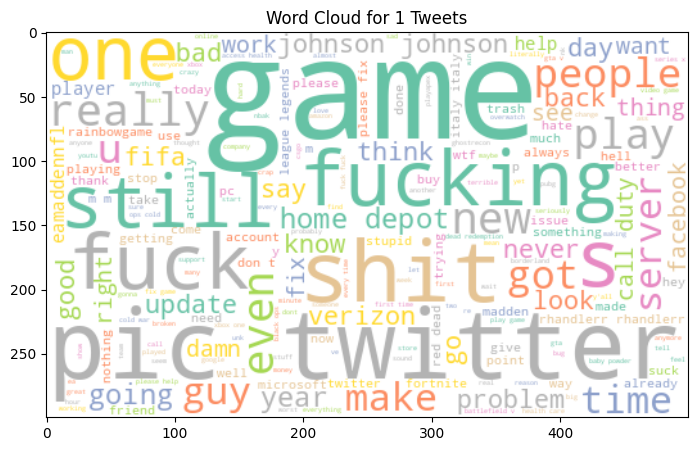

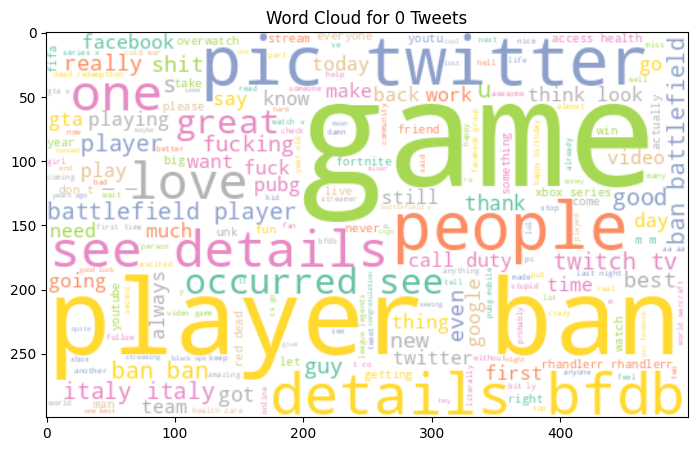

In [17]:
from wordcloud import WordCloud

def plot_wordcloud(sentiment_label):
    text = ' '.join(train_df[train_df['Sentiment'] == sentiment_label]['clean_text'].dropna())
    wordcloud = WordCloud(width=500, height=300, background_color='white', colormap='Set2').generate(text)

    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {sentiment_label} Tweets')
    plt.show()

for sentiment in train_df['Sentiment'].unique():
    plot_wordcloud(sentiment)


## 3. Comparison of Tweet Length Before and After Cleaning

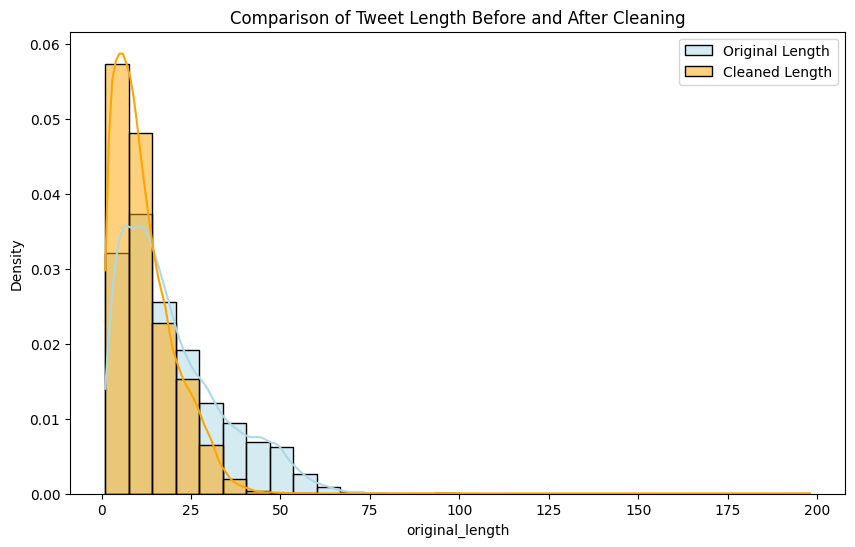

In [18]:
train_df['original_length'] = train_df['Tweet_Content'].apply(lambda x: len(str(x).split()))
train_df['cleaned_length'] = train_df['clean_text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10,6))
sns.histplot(train_df['original_length'], color='lightblue', kde=True, label='Original Length', bins=30, stat='density')
sns.histplot(train_df['cleaned_length'], color='orange', kde=True, label='Cleaned Length', bins=30, stat='density')

plt.title('Comparison of Tweet Length Before and After Cleaning')
plt.legend()
plt.show()


# 🧠 Text Vectorization

In [19]:
x = train_df['clean_text']
y = train_df['Sentiment']


In [20]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [21]:
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,3)) # uses 10000 importent features and uses 1 word or w wod together
x_train_vec = vectorizer.fit_transform(x_train)
x_test_vec = vectorizer.transform(x_test)

# 🤖 Model Training & Evaluation

In [22]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier()
}

In [23]:
for name, model in models.items():
    print(f"\nTraining: {name}")
    model.fit(x_train_vec, y_train)
    y_pred = model.predict(x_test_vec)
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=le.classes_))


Training: Logistic Regression
Accuracy: 0.7412
              precision    recall  f1-score   support

  Irrelevant       0.73      0.61      0.66      2494
    Negative       0.75      0.83      0.78      4402
     Neutral       0.74      0.70      0.72      3580
    Positive       0.74      0.77      0.75      4005

    accuracy                           0.74     14481
   macro avg       0.74      0.73      0.73     14481
weighted avg       0.74      0.74      0.74     14481


Training: Naive Bayes
Accuracy: 0.6757
              precision    recall  f1-score   support

  Irrelevant       0.78      0.40      0.53      2494
    Negative       0.66      0.83      0.73      4402
     Neutral       0.72      0.58      0.64      3580
    Positive       0.65      0.77      0.70      4005

    accuracy                           0.68     14481
   macro avg       0.70      0.64      0.65     14481
weighted avg       0.69      0.68      0.67     14481


Training: Random Forest
Accuracy: 0.8997


# 🔧 Use val_df for Evaluation

## 1. preprocessing   

In [24]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 4 columns):
 #   Column                                                                                                                                                                                                                                              Non-Null Count  Dtype 
---  ------                                                                                                                                                                                                                                              --------------  ----- 
 0   3364                                                                                                                                                                                                                                                999 non-null    int64 
 1   Facebook                                                                   

In [25]:
val_df.columns = ['Tweet_ID', 'Entity', 'Sentiment', 'Tweet_Content']

In [26]:
val_df = val_df.dropna(subset=['Tweet_Content'])

val_df['clean_text'] = val_df['Tweet_Content'].apply(preprocess_text)

In [27]:
val_df.head()

,Tweet_ID,Entity,Sentiment,Tweet_Content,clean_text
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...,bbc news - amazon boss jeff bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...,pay word functions poorly chromebook?
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,...","csgo matchmaking full closet hacking, truly aw..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...,president slapping americans face really commi...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...,hi i’ve madeleine mccann cellar past years lit...


In [28]:
val_df['Sentiment']=le.fit_transform(val_df['Sentiment'])

In [29]:
val_df = val_df.dropna(subset=['clean_text']) 

In [30]:
x_val = vectorizer.transform(val_df['clean_text'])
y_val = val_df['Sentiment']


# Evaluation on validation data 

In [31]:
best_model = RandomForestClassifier()
best_model.fit(x_train_vec, y_train)

RandomForestClassifier()

In [32]:
y_val_pred = best_model.predict(x_val)

# Evaluate
val_acc = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_acc:.4f}")
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=le.classes_))

Validation Accuracy: 0.9459
Validation Classification Report:
              precision    recall  f1-score   support

  Irrelevant       0.99      0.91      0.95       171
    Negative       0.91      0.98      0.94       265
     Neutral       0.95      0.93      0.94       285
    Positive       0.96      0.95      0.95       277

    accuracy                           0.95       998
   macro avg       0.95      0.94      0.95       998
weighted avg       0.95      0.95      0.95       998

